In [1]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
#sns.set_style('whitegrid')
import h5py
from PIL import Image
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/Users/james/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [5]:
data = pd.read_table('test_data.csv',sep=',',index_col=0)
data.head()

,stkcd,date,S_VAL_MV,S_VAL_PE_TTM,S_VAL_PE,S_VAL_PB_NEW,TOT_SHR_TODAY,OPER_REV_TTM,S_DQ_ADJCLOSE
612858,000001.SZ,20150105,1.830268e+07,9.5183,12.0167,1.4442,1.142489e+06,6.949500e+10,1138.28
612862,000001.SZ,20150106,1.802848e+07,9.3757,11.8367,1.4225,1.142489e+06,6.949500e+10,1121.23
612863,000001.SZ,20150107,1.768574e+07,9.1974,11.6117,1.3955,1.142489e+06,6.949500e+10,1099.91
612864,000001.SZ,20150108,1.709164e+07,8.8885,11.2216,1.3486,1.142489e+06,6.949500e+10,1062.96
612865,000001.SZ,20150109,1.722874e+07,8.9598,11.3116,1.3594,1.142489e+06,6.949500e+10,1071.49


In [24]:
####去极值
def MAD_filter(values, n=60):
    '''
    Parameter:
        data: inputdata. (list)
        n: how many times new median. (int)
    Return:
        filtered data. (pd.DataFrame)
    '''
    
    median = numpy.median(values)
    new_median = numpy.median( np.abs(values - median) ) 
    min_range = median - n * new_median
    max_range = median + n * new_median
    return np.clip(values, min_range, max_range)

In [27]:
from copy import deepcopy
data_clip = deepcopy(data)
for col in data.columns[2:]:
    print (col)
    data_clip.loc[:,col] = MAD_filter(data.loc[:,col].values, n=60)

S_VAL_MV
S_VAL_PE_TTM
S_VAL_PE
S_VAL_PB_NEW
TOT_SHR_TODAY
OPER_REV_TTM
S_DQ_ADJCLOSE


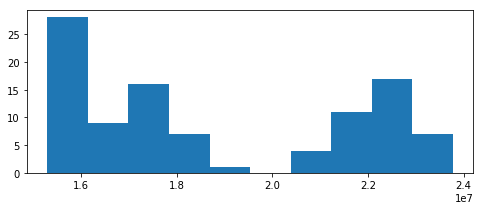

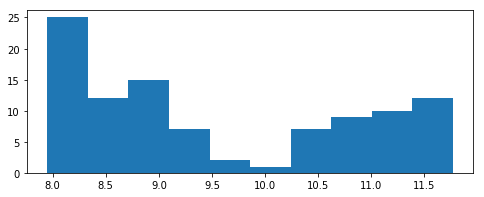

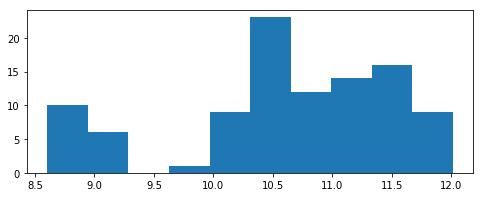

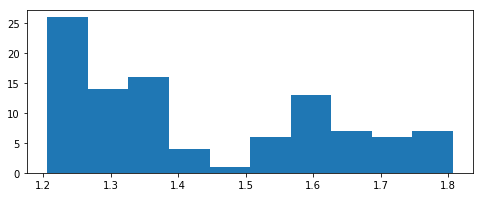

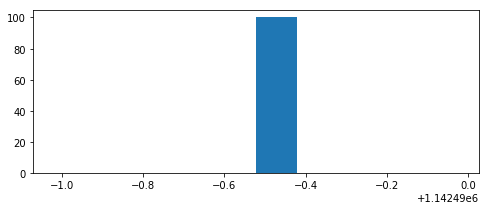

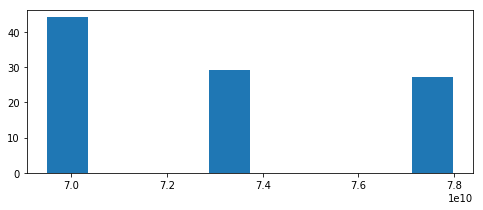

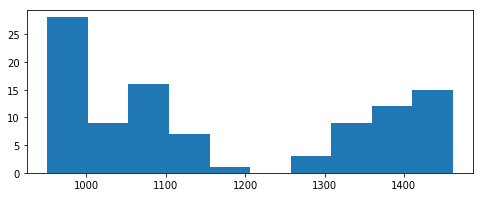

In [32]:
for i in range(7):
    fig,ax=plt.subplots(figsize=(8,3))
    ax.hist(data_clip.iloc[:,2+i])

In [47]:
#虚构一个ret
data['ret'] = np.random.random(size=100)

In [48]:
data

,stkcd,date,S_VAL_MV,S_VAL_PE_TTM,S_VAL_PE,S_VAL_PB_NEW,TOT_SHR_TODAY,OPER_REV_TTM,S_DQ_ADJCLOSE,ret
612858,000001.SZ,20150105,1.830268e+07,9.5183,12.0167,1.4442,1.142489e+06,6.949500e+10,1138.28,0.475284
612862,000001.SZ,20150106,1.802848e+07,9.3757,11.8367,1.4225,1.142489e+06,6.949500e+10,1121.23,0.292968
612863,000001.SZ,20150107,1.768574e+07,9.1974,11.6117,1.3955,1.142489e+06,6.949500e+10,1099.91,0.293454
612864,000001.SZ,20150108,1.709164e+07,8.8885,11.2216,1.3486,1.142489e+06,6.949500e+10,1062.96,0.200928
612865,000001.SZ,20150109,1.722874e+07,8.9598,11.3116,1.3594,1.142489e+06,6.949500e+10,1071.49,0.363175
...,...,...,...,...,...,...,...,...,...,...
606903,000001.SZ,20150527,2.358070e+07,11.5722,11.9082,1.6301,1.430868e+06,7.797800e+10,1417.18,0.659018
606905,000001.SZ,20150528,2.217845e+07,10.8841,11.2001,1.5332,1.430868e+06,7.797800e+10,1332.91,0.147094
606906,000001.SZ,20150529,2.192089e+07,10.7577,11.0700,1.5154,1.430868e+06,7.797800e+10,1317.43,0.141282
606907,000001.SZ,20150601,2.275080e+07,11.1649,11.4891,1.5728,1.430868e+06,7.797800e+10,1367.31,0.405739


In [67]:
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

def get_residual(data, factor_name, scale=False):
    '''
    use data.loc[factor_name] as x
    check that X is n_samples*1 shape!! it is important, the model only accept 2D array! and the shape must be n*1
    '''
    reg = linear_model.LinearRegression()
    X = np.array(data[factor_name]).reshape(-1,1)
    if scale:
        scaler = MinMaxScaler(feature_range = (0,1))
        X = scaler.fit_transform(X)
    y = X**3
    res = (y - reg.fit(X,y).predict(X)).ravel()
    return res
for col in data.columns[2:]:
    print (col)
    print (get_residual(data, col,scale=True))

S_VAL_MV
[-0.13637705 -0.11996777 -0.09664198 -0.04990303 -0.06131724 -0.03116131
 -0.02202185 -0.03517117 -0.08565419 -0.08737706  0.07039931  0.07039931
  0.00520686  0.01813564  0.00734716  0.01380331  0.05236848  0.04454815
  0.0624866   0.05910654  0.09316732  0.05685715  0.08403606  0.07493563
  0.10690567  0.10575942  0.07720743  0.08175777  0.06700391  0.05685715
  0.06023244  0.05236848  0.07380061  0.04343482  0.05236848  0.04789406
  0.09659797  0.1000315   0.12181894  0.11493395  0.03456562  0.07720743
  0.06700391 -0.01376851 -0.05278871 -0.09078781 -0.08993953 -0.09910522
 -0.07146695 -0.08304836 -0.09247547 -0.08565419 -0.04504764 -0.06411594
 -0.06131724 -0.11099376 -0.11777058 -0.13247496 -0.12141507 -0.12497125
 -0.1736226  -0.17151303 -0.16844488  0.02886278  0.03790283 -0.01313085
  0.06388954  0.15790549  0.13769074 -0.01313085  0.04250434  0.14339311
  0.06633471 -0.04297465  0.01142884  0.07625462  0.06388954  0.07625462
  0.03335571 -0.08750959 -0.1062494  -0.11